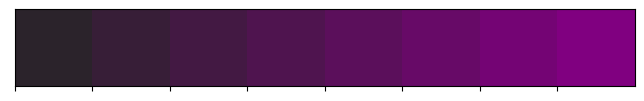

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
sources_path = './../sources'
if sources_path not in sys.path:
    sys.path.append(sources_path)
import utils
from funk_svd.svd import SVD
import mab
import joblib
import pickle
import boto3
from IPython.display import clear_output
data_dir = './../data'
plots_dir = './plots/'
progbar = utils.ProgressBar(elapsed_time=True)

config = utils.load_json_file(os.path.join(sources_path, "config.json"))

palette = config["palette"]
second_palette = config["custom_palette"]

sns_palette = sns.dark_palette(palette, n_colors=8)
sns.palplot(sns_palette)
sns.set_palette(sns_palette)
sns.set(font_scale=1.2)

In [2]:
pip install funk_svd

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement funk_svd (from versions: none)
ERROR: No matching distribution found for funk_svd


In [3]:
profile = pd.read_csv(os.path.join(data_dir, "profile.csv"), sep=';', usecols=["person", "income"])
profile = profile.set_index(["person"])
df_offers = pd.read_csv(os.path.join(data_dir, 'df_offers.csv'), sep=';')

In [4]:
df_offers.head()

,person,time,offer_id,offer_viewed,time_to_viewed,offer_completed,time_to_completed,amount,transaction_without_completion,future_purchase,...,bogo,informational,discount,offered_reward,gender,age,became_member_on,income,days_since_subscription,reward
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,1,24,0,NaN,0.00,1,0,...,0,1,0,0,M,33.0,2017-04-21,72000.0,2175,1
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,1,36,0,NaN,0.00,1,0,...,0,1,0,0,M,33.0,2017-04-21,72000.0,2175,1
2,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,1,48,1,6.0,8.57,0,1,...,1,0,0,5,M,33.0,2017-04-21,72000.0,2175,8
3,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,1,36,1,24.0,14.11,0,1,...,0,0,1,2,M,33.0,2017-04-21,72000.0,2175,5
4,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,1,36,1,0.0,10.27,0,1,...,0,0,1,2,M,33.0,2017-04-21,72000.0,2175,5


In [5]:
df_ratings = df_offers[["person", "offer_id", "reward"]].copy()
df_ratings.rename({"person": "u_id", "offer_id": "i_id", "reward": "rating"}, axis=1, inplace=True)
df_ratings = df_ratings.groupby(["u_id", "i_id"]).mean().reset_index()

In [6]:
%%time
n_folds = 5
ss = ShuffleSplit(n_splits=n_folds, train_size=.75, test_size=.2, random_state=0)
arr_n_factors = [20, 40, 60, 80, 100, 150, 200]
k = config["top_k"]
threshold = config["reward_threshold"] # Minimum mean reward for the offer to be recommended

df_eval = pd.DataFrame(
    columns=["n_factors", "fold", 
            "train_mae", "val_mae", "test_mae", 
            "train_rmse", "val_rmse", "test_rmse",
            "train_prec_at_"+str(k), "val_prec_at_"+str(k), "test_prec_at_"+str(k),
            "train_recall_at_"+str(k), "val_recall_at_"+str(k), "test_recall_at_"+str(k)]
)

for n_factors in arr_n_factors:
    print ("Running analysis for {} factors".format(n_factors))
    for fold, [train_index, val_index] in enumerate(ss.split(df_ratings.values)):
        print ("\tFold ", fold)
        
        train = df_ratings.iloc[train_index]
        val = df_ratings.iloc[val_index]
        test = df_ratings[~df_ratings.index.isin(np.concatenate([train_index, val_index]))]                
        
        svd = SVD(learning_rate=0.001, regularization=0.05, n_epochs=100, 
                  n_factors=n_factors, verbose=False)
        svd.fit(X=train, X_val=val, early_stopping=True, shuffle=False)
        
        train["prediction"] = svd.predict(train, clip=False)
        val["prediction"] = svd.predict(val, clip=False)
        test["prediction"] = svd.predict(test, clip=False)
        
        row = [
            n_factors, fold, 
            utils.mean_absolute_error(train),
            utils.mean_absolute_error(val),
            utils.mean_absolute_error(test),
            utils.root_mean_squared_error(train),
            utils.root_mean_squared_error(val),
            utils.root_mean_squared_error(test),
            utils.precision_at_k(train, k, threshold),
            utils.precision_at_k(val, k, threshold),
            utils.precision_at_k(test, k, threshold),
            utils.recall_at_k(train, k, 7),
            utils.recall_at_k(val, k, 7),
            utils.recall_at_k(test, k, 7)
        ]
        
        df_eval.loc[df_eval.shape[0]] = row
        
clear_output()

CPU times: total: 1min 14s
Wall time: 1min 52s


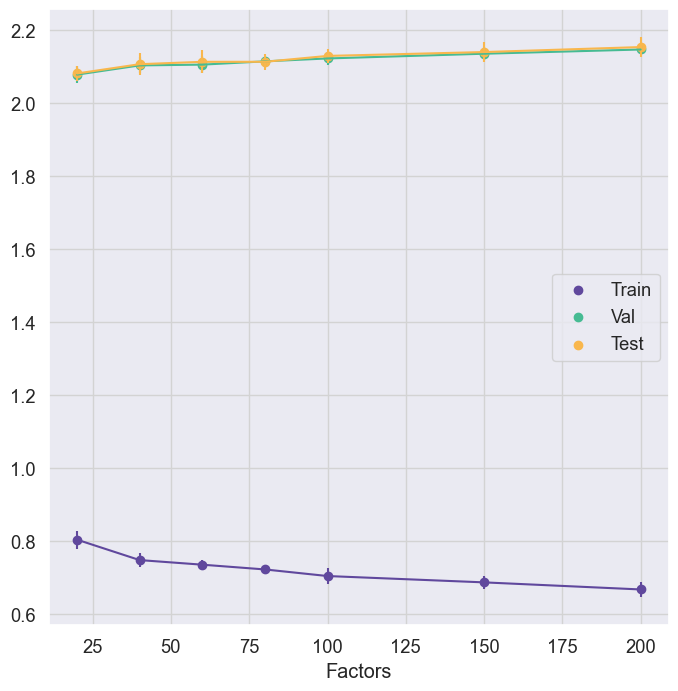

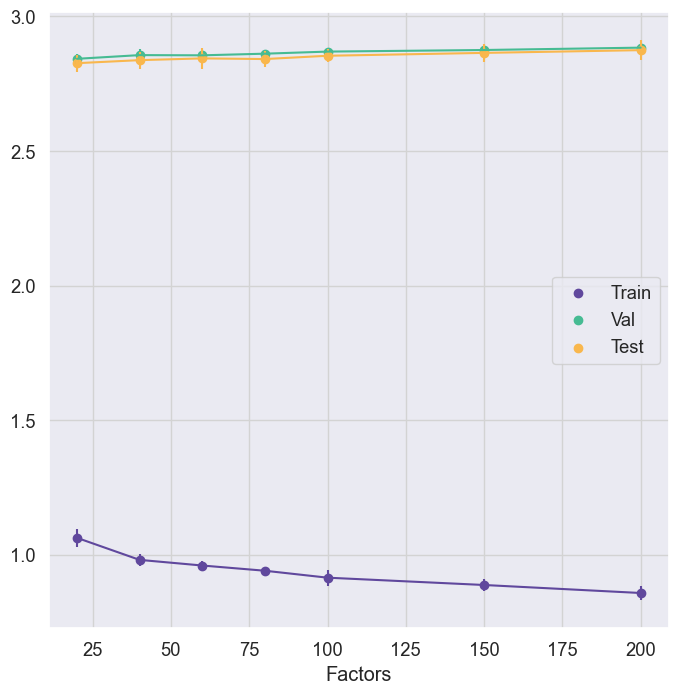

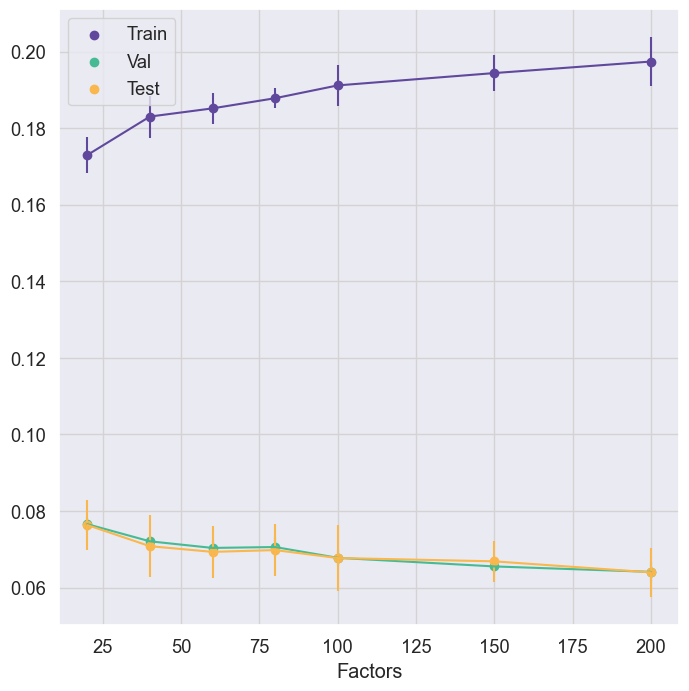

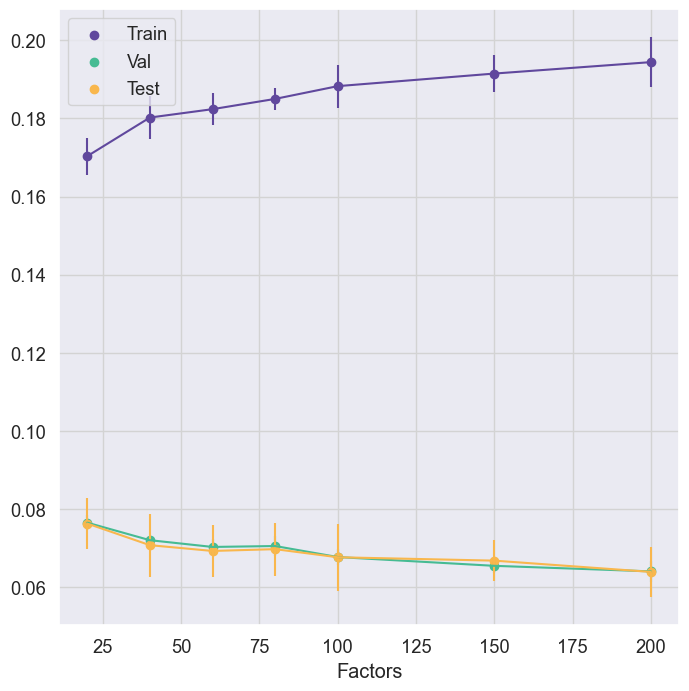

In [7]:
df_plot = df_eval.groupby(["n_factors"]).mean()
df_plot_std = df_eval.groupby(["n_factors"]).std()

for metric in ["mae", "rmse", "prec_at_" + str(k), "recall_at_" + str(k)]:
    fig, ax = plt.subplots(figsize=(8,8))
    for i, metric_set in enumerate(["train", "val", "test"]):
        ax.errorbar(df_plot.index, 
                    df_plot['_'.join([metric_set, metric])], 
                    df_plot_std['_'.join([metric_set, metric])],
                    color=second_palette[i])
        ax.scatter(df_plot.index, df_plot['_'.join([metric_set, metric])], 
                label=metric_set.title(), color=second_palette[i])

    ax.legend()
    ax.set_xlabel("Factors")
    ax.grid(True, color="lightgray")
    filename = "{}_factors_{}_folds.jpeg".format(metric, n_folds)
    fig.savefig(os.path.join(plots_dir, filename), bbox_inches="tight")

In [8]:
n_factors = config["n_factors"]

In [9]:
%%time
n_folds = config["n_folds"]
ss = ShuffleSplit(n_splits=n_folds, train_size=.75, test_size=.2, random_state=0)
arr_k = np.arange(1, df_offers["offer_id"].nunique()+1, 1)

df_eval = pd.DataFrame(columns=["k", "fold", 
                                "train_mae", "val_mae", "test_mae", 
                                "train_rmse", "val_rmse", "test_rmse",
                                "train_prec_at_k", "val_prec_at_k", "test_prec_at_k",
                                "train_recall_at_k", "val_recall_at_k", "test_recall_at_k"])

for k in arr_k:
    print ("Running analysis for k = {}".format(k))
    for fold, [train_index, val_index] in enumerate(ss.split(df_ratings.values)):
        print ("\tFold ", fold)
        
        train = df_ratings.iloc[train_index]
        val = df_ratings.iloc[val_index]
        test = df_ratings[~df_ratings.index.isin(np.concatenate([train_index, val_index]))]                
        
        svd = SVD(learning_rate=0.001, regularization=0.05, n_epochs=100, 
                  n_factors=n_factors, verbose=False)
        svd.fit(X=train, X_val=val, early_stopping=True, shuffle=False)
        
        train["prediction"] = svd.predict(train, clip=False)
        val["prediction"] = svd.predict(val, clip=False)
        test["prediction"] = svd.predict(test, clip=False)
        
        row = [
            k, fold, 
            utils.mean_absolute_error(train),
            utils.mean_absolute_error(val),
            utils.mean_absolute_error(test),
            utils.root_mean_squared_error(train),
            utils.root_mean_squared_error(val),
            utils.root_mean_squared_error(test),
            utils.precision_at_k(train, k, threshold),
            utils.precision_at_k(val, k, threshold),
            utils.precision_at_k(test, k, threshold),
            utils.recall_at_k(train, k, 7),
            utils.recall_at_k(val, k, 7),
            utils.recall_at_k(test, k, 7)
        ]
        
        df_eval.loc[df_eval.shape[0]] = row

Running analysis for k = 1
	Fold  0

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  1

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  2

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  3

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  4

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running analysis for k = 2
	Fold  0

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  1

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  2

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  3

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  4

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running analysis for k = 3
	Fold  0

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  1

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  2

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  3

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  4

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running analysis for k = 4
	Fold  0

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  1

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  2

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  3

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  4

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running analysis for k = 5
	Fold  0

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  1

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  2

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  3

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  4

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running analysis for k = 6
	Fold  0

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  1

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  2

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  3

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  4

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running analysis for k = 7
	Fold  0

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  1

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  2

Training took 3 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  3

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  4

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running analysis for k = 8
	Fold  0

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  1

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  2

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  3

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  4

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running analysis for k = 9
	Fold  0

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  1

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  2

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  3

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  4

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running analysis for k = 10
	Fold  0

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  1

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  2

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  3

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


	Fold  4

Training took 2 sec


<timed exec>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: total: 1min 49s
Wall time: 2min 36s


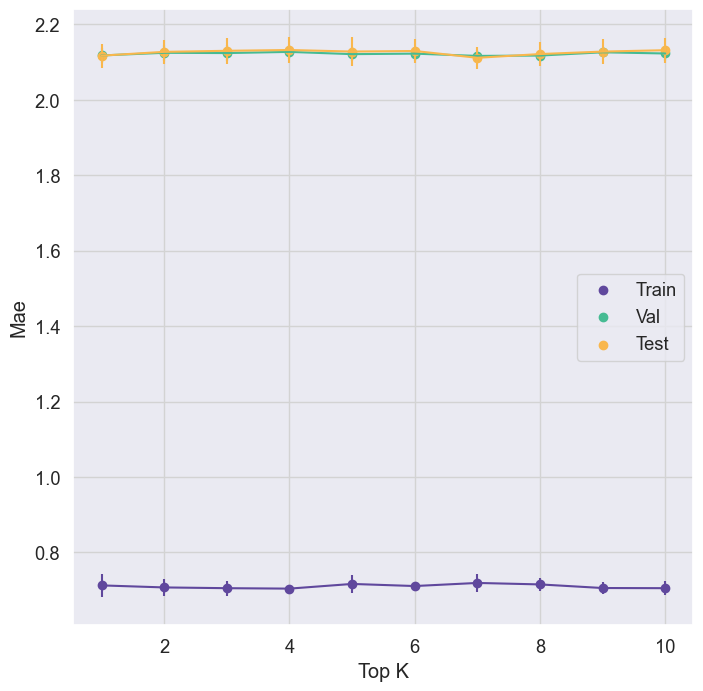

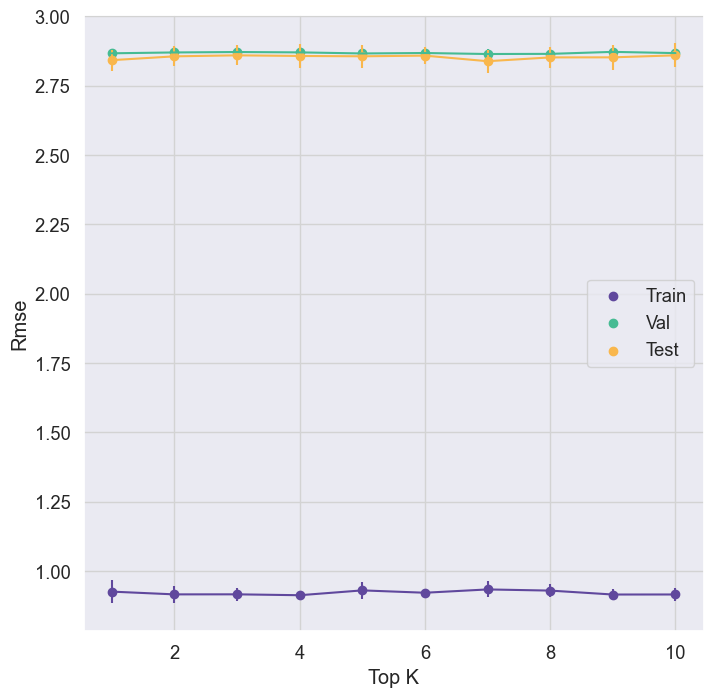

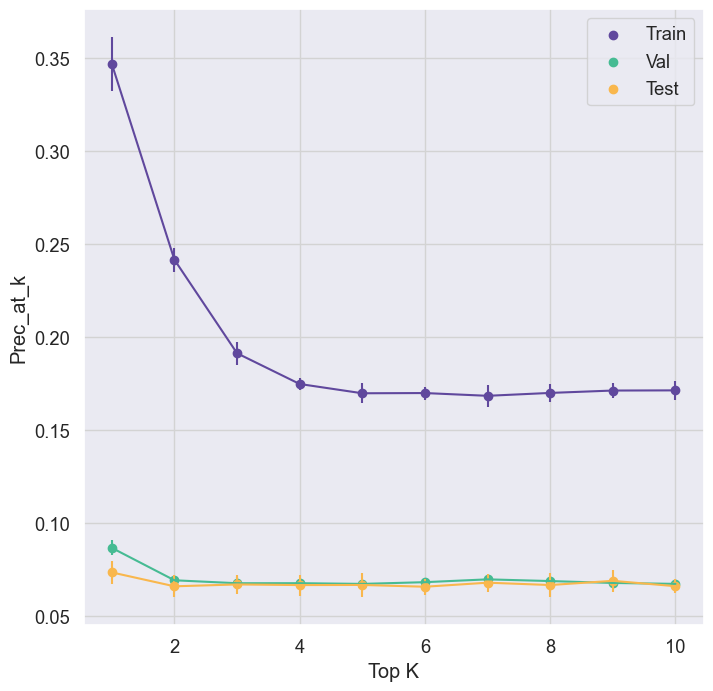

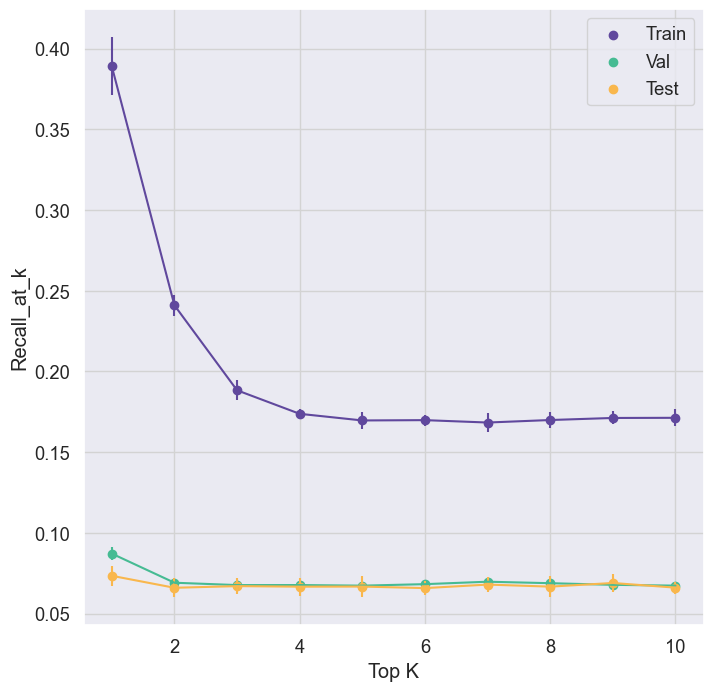

In [10]:
df_plot = df_eval.groupby(["k"]).mean()
df_plot_std = df_eval.groupby(["k"]).std()
for metric in ["mae", "rmse", "prec_at_k", "recall_at_k"]:
    fig, ax = plt.subplots(figsize=(8,8))
    for i, metric_set in enumerate(["train", "val", "test"]):
        ax.errorbar(df_plot.index, 
                    df_plot['_'.join([metric_set, metric])], 
                    df_plot_std['_'.join([metric_set, metric])],
                    color=second_palette[i], label=None)
        ax.scatter(df_plot.index, df_plot['_'.join([metric_set, metric])], 
                label=metric_set.title(), color=second_palette[i])

    ax.legend()
    ax.set_xlabel("Top K"), ax.set_ylabel(metric.capitalize())
    ax.grid(True, color="lightgray")
    filename = "{}_top_k_{}_folds.jpeg".format(metric, n_folds)
    fig.savefig(os.path.join(plots_dir, filename), bbox_inches="tight")

In [11]:
# Extracting fully-densed utility matrix
df_matrix_original = svd.get_utility_matrix(df_ratings)

# Getting all u_id and i_id combinations
df_predictions= pd.melt(df_matrix_original.reset_index(drop=False), id_vars='u_id')
df_predictions.rename({"value": "rating"}, axis=1, inplace=True)

In [12]:
df_predictions["rating"] = svd.predict(df_predictions, clip=False)
df_matrix_predictions = svd.get_utility_matrix(df_predictions)
# df_matrix_predictions.to_csv(os.path.join(data_dir, "df_matrix_predictions.csv"), sep=';', index=None)

In [13]:
df_cluster = pd.merge(profile, df_matrix_predictions, how="inner", left_index=True, right_index=True)

In [14]:
silhouette_avg = list()
arr_n_clusters = np.arange(2, 20, 1)
X = df_cluster.values
#.drop(["gender", "became_member_on", "days_since_subscription", "age", "gender_clean"], axis=1).values
df_silhouette_avg = pd.DataFrame(columns = ["fold", "n_cluster", "train_silhouette", "test_silhouette"])
trained_models = list()

for fold, [train_index, val_index] in enumerate(ss.split(X)):
    
    print ("Running analysis on fold {}".format(fold))
    X_train, X_val = X[train_index], X[val_index]
    
    for n_cluster in arr_n_clusters:        
        model = KMeans(n_clusters=n_cluster, random_state=0)
        
        model.fit(X_train)
        train_silhouette = silhouette_score(X_train, model.predict(X_train))
        val_silhouette = silhouette_score(X_val, model.predict(X_val))

        row = [fold, n_cluster, train_silhouette, val_silhouette]
        df_silhouette_avg.loc[df_silhouette_avg.shape[0]] = row   

Running analysis on fold 0
Running analysis on fold 1
Running analysis on fold 2
Running analysis on fold 3
Running analysis on fold 4


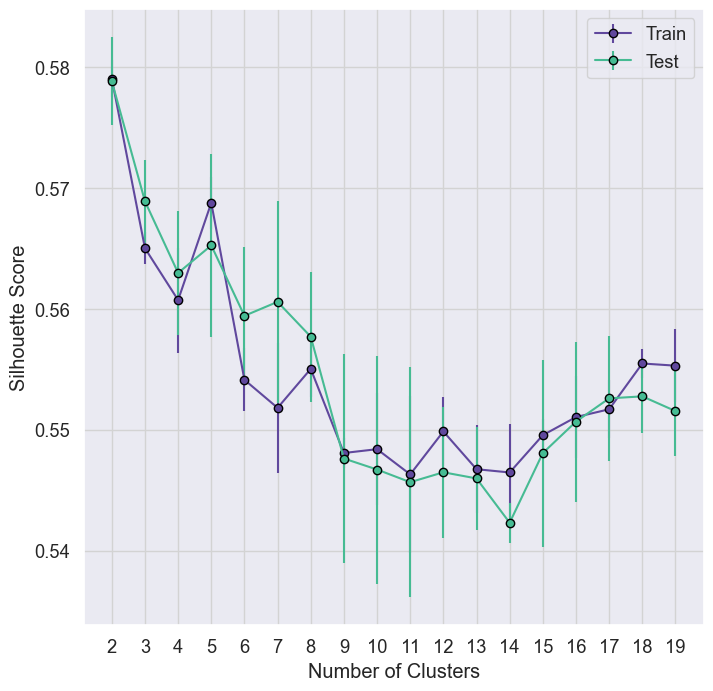

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
df_plot = df_silhouette_avg.groupby("n_cluster")
for i, set_label in enumerate(["train", "test"]):
    ax.errorbar(df_plot.mean().index, 
                df_plot.mean()[set_label + "_silhouette"].values, 
                df_plot.std()[set_label + "_silhouette"].values, label=set_label.title(),
               marker='o', mec='black', color = second_palette[i])
ax.set_xticks(arr_n_clusters), ax.set_xticklabels(arr_n_clusters)

ax.grid(True, color="lightgray")
ax.legend()
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Score")
filename = "silhouette_score.jpg"
fig.savefig(os.path.join(plots_dir, filename), bbox_inches="tight")

Considering the silhouette score, a proper number of clusters would be $5$

In [16]:
import sagemaker
# from sagemaker import get_execution_role

session = sagemaker.Session()

# get IAM role
# role = sagemaker.get_execution_role()
# print(role)

In [17]:
bucket = session.default_bucket()
prefix = "sagemaker/capstone"

output_path='s3://{}/{}/'.format(bucket, prefix)

### Training the final K-Means model

In [18]:
n_clusters = config["n_clusters"]
model = KMeans(n_clusters=n_clusters, random_state=0, verbose=False)
model.fit(X)

KMeans(n_clusters=5, random_state=0, verbose=False)

### Defining clusters rewards

In [19]:
df_clusters_rewards = pd.DataFrame(model.cluster_centers_)
df_clusters_rewards.columns = df_cluster.columns
df_clusters_rewards = df_clusters_rewards.reset_index(drop=False).rename({"index": "cluster"},axis=1).set_index("cluster")
df_clusters_rewards.drop(["income"], axis=1, inplace=True)
df_clusters_rewards.to_csv(os.path.join(data_dir, "df_clusters_rewards.csv"), sep=';')
df_clusters_rewards

,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
cluster,,,,,,,,,,
0,4.499829,4.357031,3.169724,1.158475,6.594231,1.156630,5.056506,7.097385,4.963292,3.827781
1,3.585954,3.892364,2.751805,1.139968,5.143028,1.139804,4.307696,5.616372,4.263570,3.414985
2,4.964330,4.554783,3.364279,1.162570,7.272860,1.160276,5.377741,7.876134,5.259298,4.014961
3,4.136725,4.175070,3.010260,1.149988,6.052384,1.148757,4.756787,6.544336,4.707431,3.666611
4,4.992802,4.590358,3.360968,1.161431,7.454951,1.159729,5.348506,7.798731,5.320887,4.035727


In [20]:
from mab.greedy import EGreedyDecay

In [21]:
%%time

T = 30000
realizations = 20
epsilon = config["epsilon"]
beta = config["beta"]
print ('Starting MAB Experiment')

mean_reward_hist = pd.DataFrame(columns=[i for i in np.arange(T+1)] + ["realization"])

for realization in np.arange(realizations):
    progbar.update_progress(realization/realizations)
    last_reward = np.zeros(n_clusters)
    bandits = [EGreedyDecay(epsilon=epsilon, beta=beta) for _ in np.arange(n_clusters)]
    for i in np.arange(n_clusters):
        bandits[i].set_rewards(df_clusters_rewards.loc[i])

    temp_mean_reward_hist = dict()
    for cluster in np.arange(n_clusters):
        temp_mean_reward_hist[cluster] = []

    for t in range(1,T):
        for cluster in np.arange(n_clusters):
            item = bandits[cluster].pull_arm(last_reward[cluster])
            last_reward[cluster] = bandits[cluster].get_reward(item)
            temp_mean_reward_hist[cluster].append(bandits[cluster].mean_reward)

    temp_mean_reward_hist = pd.DataFrame(temp_mean_reward_hist).T
    temp_mean_reward_hist["realization"] = realization
    mean_reward_hist = pd.concat([mean_reward_hist, temp_mean_reward_hist], sort=False)
     
mean_reward_hist = mean_reward_hist.reset_index(drop=False).rename({"index": "cluster"}, axis=1)

Starting MAB Experiment
[0:01:58][##########] 95.00% CPU times: total: 1min 25s
Wall time: 2min 5s


In [22]:
print(mean_reward_hist.dtypes)

cluster         int64
0              object
1              object
2              object
3              object
                ...  
29997          object
29998          object
29999          object
30000          object
realization    object
Length: 30003, dtype: object


In [23]:
mean_reward_hist['realization'] = mean_reward_hist['realization'].astype(int)

Saving file at  EGreedyDecay_mean_average_reward_20_realizations.jpeg


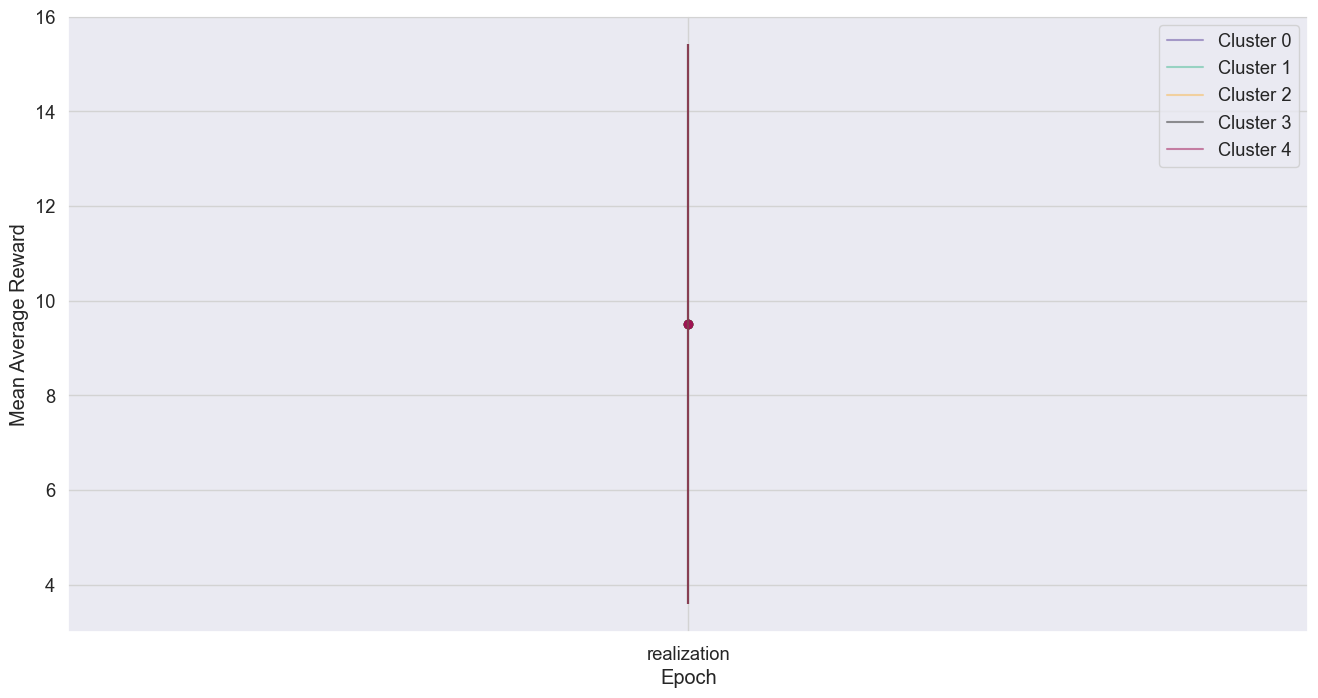

In [24]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(16,8))

df_plot_mean = mean_reward_hist.groupby(["cluster"]).mean() #[np.arange(0, T, 2000)]
df_plot_std = mean_reward_hist.groupby(["cluster"]).std() #[np.arange(0, T, 2000)]

n_clusters = len(df_plot_mean)

for cluster in range(n_clusters):
    ax.plot(df_plot_mean.iloc[cluster].index, 
            df_plot_mean.iloc[cluster].values,
            label = "Cluster " + str(cluster),
            color=second_palette[cluster], alpha=0.5)

    ax.errorbar(df_plot_mean.iloc[cluster].index,
                df_plot_mean.iloc[cluster].values,
                df_plot_std.iloc[cluster].values,
                color=second_palette[cluster],
                alpha=0.5, label=None)

    ax.scatter(x=[df_plot_mean.iloc[cluster].index[-1]], y=[df_plot_mean.iloc[cluster].values[-1]],
               color=second_palette[cluster], label=None)

ax.set_xlabel("Epoch"), ax.set_ylabel("Mean Average Reward")
ax.legend()
ax.grid(True, color="lightgray")

filename = "{}_mean_average_reward_{}_realizations.jpeg".format(str(bandits[0]), int(realizations))
print("Saving file at ", filename)
fig.savefig(os.path.join(plots_dir, filename), bbox_inches="tight")


7 [  932.   949.   936.   905.  1010.   928.   955. 21418.   946.  1020.]
6 [  906.   998.   937.   920.   971.   993. 21426.   963.   965.   920.]
4 [  950.   914.   986.   960. 21352.   913.   951.   992.   984.   997.]
7 [  961.   991.   969.   985.   934.   974. 10599. 11686.   969.   931.]
4 [  937.   981.   926.   983. 21484.   958.   910.   910.   957.   953.]


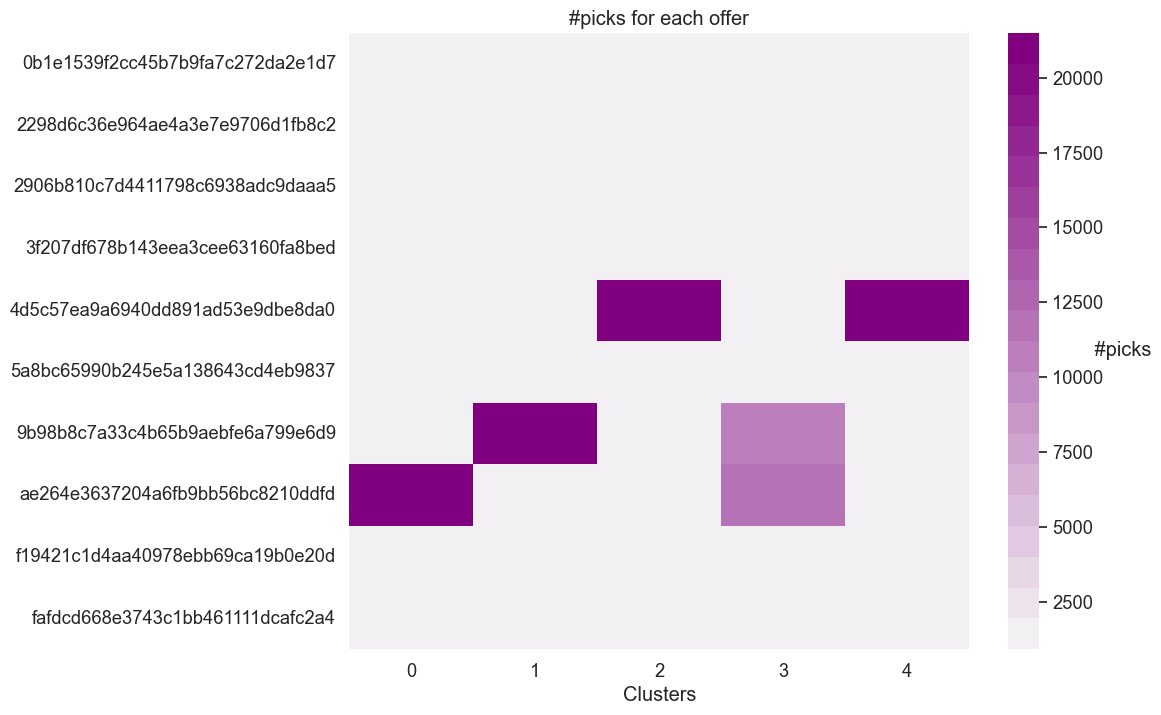

In [25]:
picks = np.zeros([n_clusters, bandits[0].k])
for cluster, bandit in enumerate(bandits):
    picks[cluster] = bandit.k_n
    print(np.argmax(bandit.k_n), bandit.k_n)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(picks.T, ax=ax, cmap=sns.light_palette(palette, n_colors=20))
ax.set_xlabel("Clusters")
ax.set_yticklabels([product for product in df_clusters_rewards.columns], rotation = 0)
ax.collections[0].colorbar.set_label("     #picks", rotation=0)
ax.set_title("#picks for each offer")
filename = "picks_by_cluster.jpg"
fig.savefig(os.path.join(plots_dir, filename), bbox_inches="tight")

### Saving Models

In [64]:
with open('C:/Users/krish/Downloads/promotions/data/trained_svd.pkl','wb') as file:
    pickle.dump(svd, file)
with open('C:/Users/krish/Downloads/promotions/data/trained_kmeans.pkl','wb') as file:
    pickle.dump(model, file)

for cluster, bandit in enumerate(bandits):
#     joblib.dump(bandit, os.path.join(data_dir, "trained_mab", "trained_{}_cluster_{}.joblib".format(str(bandit), cluster)))
#     joblib.dump(bandit, ("C:/Users/krish/Downloads/promotions/data/trained_mab/trained_{}_cluster_{}.joblib".format(str(bandit), cluster)))
    joblib.dump(bandit, ("C:/Users/krish/Downloads/promotions/data/trained_{}_cluster_{}.joblib".format(str(bandit), cluster)))
#     with open(("C:/Users/krish/Downloads/promotions/data/trained_mab/trained_{}_cluster_{}.pkl".format(str(bandit), cluster)), 'wb') as file: 
    with open(("C:/Users/krish/Downloads/promotions/data/trained_{}_cluster_{}.pkl".format(str(bandit), cluster)), 'wb') as file: 
#     with open(os.path.join(data_dir, "trained_mab", trained_{}_cluster_{}.pkl".format(str(bandit), cluster)), 'wb') as file: 
        pickle.dump(bandit, file)

In [66]:
# session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
# print("Data Uploaded")

## Testing Recommendation

In [67]:
cred = session.boto_session.get_credentials()
s3client = boto3.client(
    's3', 
    aws_access_key_id = cred.access_key, 
    aws_secret_access_key = cred.secret_key, 
    aws_session_token = cred.token
)

In [68]:
prefix

'sagemaker/capstone'

In [69]:
user_features = df_cluster.sample().values.astype('float')
print (user_features)

[[5.80000000e+04 7.17261584e+00 5.68011856e+00 4.28078402e+00
  1.13910409e+00 1.22164528e+01 1.13936881e+00 6.56901897e+00
  9.93921388e+00 7.32149924e+00 5.07889307e+00]]


In [70]:
import pickle
# class Foo(object): pass

# a = Foo()
# with open('C:/Users/krish/Downloads/ml-engineer-capstone-master/data/trained_kmeans.pkl','wb') as f:
with open('C:/Users/krish/Downloads/promotions/data/trained_kmeans.pkl','rb') as f:
#     kmeans = pickle.dump(a,f)
    model = pickle.load(f)

In [71]:
# response = s3client.get_object(Bucket=bucket, Key=os.path.join(prefix, 'trained_kmeans.pkl'))#.decode('utf8')
# response = s3client.get_object(Bucket=bucket, Key=os.path.join(prefix, 'trained_kmeans.pkl'))#.decode('utf8')
# body = response['Body'].read()
# kmeans = kmeans.loads(body)

In [72]:
cluster = model.predict(user_features)[0]
print ("User cluster: ", cluster)

User cluster:  3


In [73]:
class Foo:
    def __init__(self):
        pass

    def predict(self, user_features):
        cluster = model.predict(user_features)[0]
        print(cluster)
        return cluster

In [75]:
# response = s3client.get_object(Bucket=bucket, Key=os.path.join(prefix, 'trained_mab/trained_EGreedyDecay_cluster_{}.pkl'.format(cluster)))#.decode('utf8')
# body = response['Body'].read()
# model = pickle.loads(body)

# with open('C:/Users/krish/Downloads/promotions/data/trained_mab/trained_EGreedyDecay_cluster_{}.pkl'.format(cluster),'rb') as f:
with open('C:/Users/krish/Downloads/promotions/data/trained_EGreedyDecay_cluster_{}.pkl'.format(cluster),'rb') as f:
    model = pickle.load(f)

In [76]:
model.pull_arm(1)

'2298d6c36e964ae4a3e7e9706d1fb8c2'